In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
train =pd.read_csv("/content/drive/MyDrive/yelp_review/train.csv", header=None, names=["Sentiment", "Review"])
test =pd.read_csv("/content/drive/MyDrive/yelp_review/test.csv", header=None, names=["Sentiment", "Review"])
train.head()

,Sentiment,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


**Exploration**

In [ ]:
train.shape

(560000, 2)

In [ ]:
test.shape

(38000, 2)

In [ ]:
train.isnull().sum()

,0
Sentiment,0
Review,0


In [ ]:
train['Review_Length'] = train['Review'].apply(len)
train.head()
train.iloc[:1]

,Sentiment,Review,Review_Length
0,1,"Unfortunately, the frustration of being Dr. Go...",643


In [ ]:
# Calculate the length of each review in the 'Review' column
train['Review_Length'] = train['Review'].apply(len)

# Display the first 5 rows to verify
train.head()

# Find the longest review
longest_review = train.loc[train['Review_Length'].idxmax()]

# Find the shortest review
shortest_review = train.loc[train['Review_Length'].idxmin()]

# Print the longest and shortest reviews
print("Longest Review:\n", longest_review['Review'])
print("\nReview Length:", longest_review['Review_Length'])

print("\n\nShortest Review:\n", shortest_review['Review'])
print("\nReview Length:", shortest_review['Review_Length'])

Longest Review:
 Francais plus bas.\n\nHey why write a Costco review, we all know what's Costco! It's the good old Club Price! YEah That place is the joke The Simpsons mock once where Barney was drunk as hell and talking to a giant bottle of honey  in the shape of a woman that falls and then he think he killed her! Yeah that Costco! Supersize item of the most common thing you need in life. Everybody I know that goes to Costco has the same issue: they can't go there and spend less than a 100$! That's the ultimate choice of being a Costco member, accepting the fact you'll be over-excited by those 1 kg (2.2lbs) of Kettle chips!  Those 72 rolls of toilet paper and those  huge 4 kg jar of Hellmans' Mayo. Can we still call it a jar at 4 kg? Regardless the only thing I think his really worth sharing about Costco are the cool things that we don't know. \n\n1) Batteries. Damn batteries, I HATE buying 4 pack of AA Duracells, makes me feel like I'm going to need more and then i'll use the one in 

In [ ]:
train.dtypes

,0
Sentiment,int64
Review,object
Review_Length,int64


In [ ]:
print(f"Sentiment value count: \n {train['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
1    280000
2    280000
Name: count, dtype: int64


<ipython-input-56-c344c2e03ac6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=train, ax=ax, palette=colors)


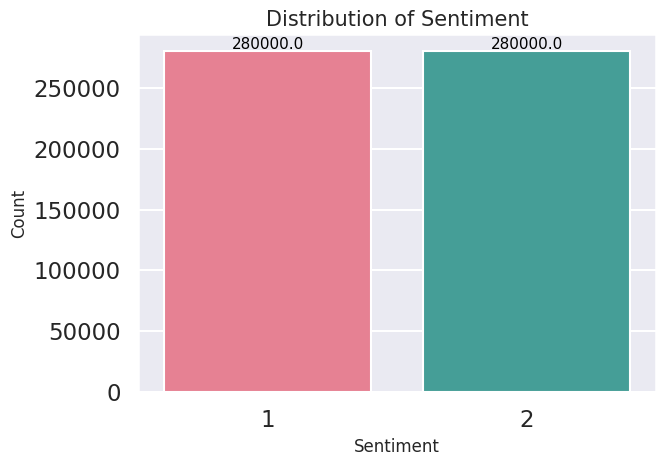

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.set_context("talk")

colors = sns.color_palette("husl", n_colors=len(train['Sentiment'].unique()))
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x="Sentiment", data=train, ax=ax, palette=colors)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11,
                color='black', xytext=(0, 5), textcoords='offset points')

ax.set_xlabel("Sentiment", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Sentiment", fontsize=15)

plt.tight_layout()
plt.show()


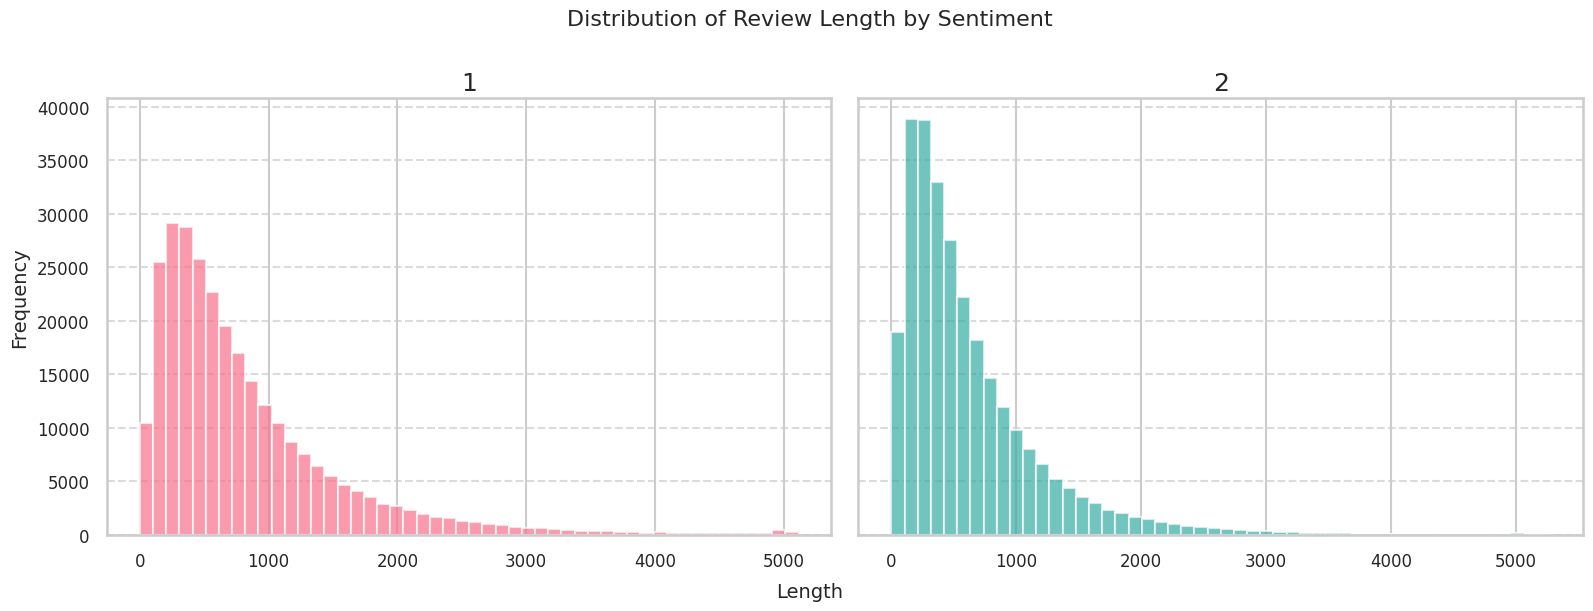

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk")

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

colors = sns.color_palette("husl", n_colors=len(train['Sentiment'].unique()))

for i, sentiment in enumerate(train['Sentiment'].unique()):
    subset = train[train['Sentiment'] == sentiment]
    axs[i].hist(subset['Review_Length'], bins=50, alpha=0.7, color=colors[i])
    axs[i].set_title(sentiment)

fig.suptitle('Distribution of Review Length by Sentiment', fontsize=16)
fig.text(0.5, 0, 'Length', ha='center', fontsize=14)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

for ax in axs:
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Preprocessing train**

In [ ]:
!pip install nltk
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the 'punkt' resource
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


def clean_text(text: str) -> str:
    text = text.lower()
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespaces(text)
    text = tokenize_and_lemmatize(text)
    return text
def remove_urls(text: str) -> str:
    return re.sub(r'https*\S+', ' ', text)
def remove_mentions_and_hashtags(text: str) -> str:
    return re.sub(r'[@#]\S+', ' ', text)
def remove_html_tags(text: str) -> str:
    return re.sub('<.*?>', '', text)
def expand_contractions(text: str) -> str:
    contractions = {"don't": 'do not', "can't": 'cannot'}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text
def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)

def remove_extra_whitespaces(text: str) -> str:
    return re.sub('\s{2,}', ' ', text)
def tokenize_and_lemmatize(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
cleaned_reviews_train = train['Review'].apply(clean_text)

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
cleaned_reviews_test = test['Review'].apply(clean_text)

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


**Preprocessing train**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(cleaned_reviews_train)
y_train = train['Sentiment']

**Preprocessing test**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_test = vectorizer.fit_transform(cleaned_reviews_test)
y_test = test['Sentiment']

**Bulding model**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
# Assuming 'train' and 'test' are your original DataFrames
# and 'text_column' is the name of the column containing the text data.

# 1. Create a TfidfVectorizer instance
vectorizer = TfidfVectorizer()

# 2. Fit the vectorizer on the training data and transform it
X_train = vectorizer.fit_transform(train['Review'])

# 3. Transform the test data using the same vectorizer
X_test = vectorizer.transform(test['Review'])

# 4. Train your model as before
model = MultinomialNB()
model.fit(X_train, y_train)

# 5. Make predictions
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8841842105263158


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[16980  2020]
 [ 2381 16619]]


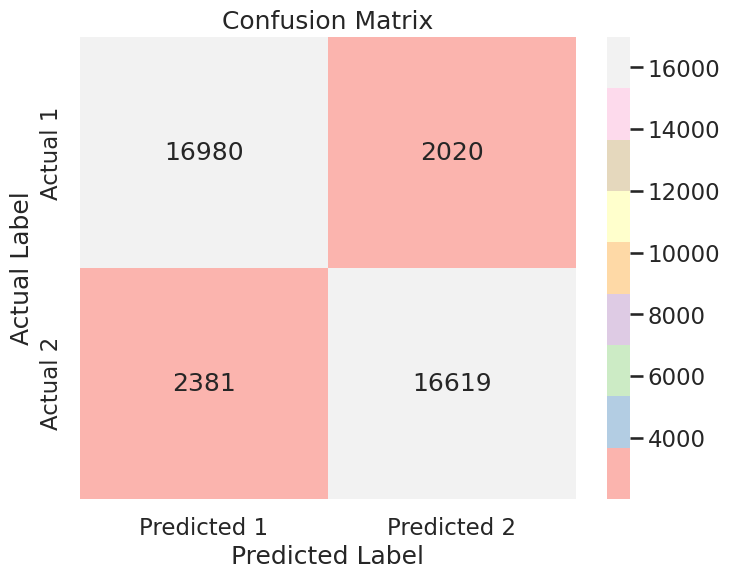

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Pastel1',
            xticklabels=['Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 1', 'Actual 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()
